# Разработка модели, определяющей ненадежного клиента для сети отелей
## Постановка задачи

Заказчик исследования — сеть отелей «Как в гостях». Поставленная задача - разработка модели, определяющей ненадежного клиента, который с высокой вероятностью отменит бронь номера.

Чтобы привлечь клиентов, сеть отелей дает возможность забронировать номер без предоплаты. Однако если клиент отменяет бронирование, то компания терпит убытки: это расходы на уборку номера, закупленные продукты, упущенная прибыль от отказа другим клиентам.

Чтобы решить эту проблему, нужно разработать модель, которая предсказывает отказ от брони. Модель предполагается использовать следующим образом. 

В случае если модель предсказывает, что бронь будет отменена, то клиенту будет предложено внести депозит. 

Размер депозита — 80 % от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он отменит бронь.

## Описание бизнес метрик и их расчета
Основная бизнес-метрика для сети отелей — прибыль. В данной работе бизнес-метрики отеля считаются следующим образом. Прибыль - это разница между выручкой и расходами. Выручка - стоимость номера за все ночи, расходы - затраты на обслуживание при подготовке номера и при проживании постояльца.

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:
* категория A: за ночь — 1 000, разовое обслуживание — 400;
* категория B: за ночь — 800, разовое обслуживание — 350;
* категория C: за ночь — 600, разовое обслуживание — 350;
* категория D: за ночь — 550, разовое обслуживание — 150;
* категория E: за ночь — 500, разовое обслуживание — 150;
* категория F: за ночь — 450, разовое обслуживание — 150;
* категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%. Сезонные коэффициенты применяются только для стоимости номеров; затраты на уборку одинаковы в течение года.

## Требования по окупаемости модели
На разработку системы прогнозирования заложен бюджет — 400_000 рублей. Внедрение модели должно окупиться за год. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

## Импорт библиотек и данных
Импортируем исходные датасеты в переменные train и test и ознакомимся с данными.

Исходные данные представляют собой два датасета с одинаковой структурой. Названия и типы столбцов одинаковы. Типы данных адекватны в целом адекватны, пропусков нет. Явные дубликаты отсутствуют.

Нужно будет изменить типы данных для столбцов `adults`, `children`, `babies` с `float` на `int`.

Столбцы с id неинформативны, их нужно будет удалить. Также удалим столбец с днем месяца `arrival_date_day_of_month`, чтоб модель не нашла ложных взаимосвязей.

Данные адекватны и пригодны для анализа.

Информацию о ценах на услуги сохраним в датасете `room_prices`. Информацию о коэффициентах сохраним в соответствующих константах.

### Импорт библиотек

In [1]:
from pathlib import Path
import math

import pandas as pd
pd.set_option('display.float_format', '{:,.4f}'.format)

from scipy import stats as st

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from numpy.random import RandomState


### Импорт датасетов

In [2]:
my_path = Path('/home/klarazetkin/Documents/yandex/module_2/integrative_project')
if my_path.is_dir():
    train = pd.read_csv('/home/klarazetkin/Documents/yandex/module_2/integrative_project/hotel_train.csv')
    test = pd.read_csv('/home/klarazetkin/Documents/yandex/module_2/integrative_project/hotel_test.csv')
else:
    train = pd.read_csv('/datasets/hotel_train.csv')
    test = pd.read_csv('/datasets/hotel_test.csv')

## Предобработка и исследовательский анализ данных
### Ознакомление с данными и проверка структуры данных

In [3]:
display(train.head())
display(test.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0000,2015,July,27,1,0,1,1.0000,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0000,2015,July,27,1,0,2,2.0000,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0000,2015,July,27,1,0,2,2.0000,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0000,2015,July,27,1,0,2,2.0000,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0000,2015,July,27,1,0,3,2.0000,...,0,0,0,A,0,0,Transient,0,1,3


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0000,2017,January,1,1,1,0,2.0000,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0000,2017,January,1,1,2,2,2.0000,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0000,2017,January,1,1,2,2,2.0000,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0000,2017,January,1,1,2,2,1.0000,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0000,2017,January,1,1,2,5,2.0000,...,0,0,0,A,0,0,Transient,0,0,7


In [4]:
# Проверим, что колонки совпадают
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [5]:
print(train.shape)
print(test.shape)

(65229, 25)
(32412, 25)


In [6]:
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
id                                65229 non-null int64
is_canceled                       65229 non-null int64
lead_time                         65229 non-null float64
arrival_date_year                 65229 non-null int64
arrival_date_month                65229 non-null object
arrival_date_week_number          65229 non-null int64
arrival_date_day_of_month         65229 non-null int64
stays_in_weekend_nights           65229 non-null int64
stays_in_week_nights              65229 non-null int64
adults                            65229 non-null float64
children                          65229 non-null float64
babies                            65229 non-null float64
meal                              65229 non-null object
country                           65229 non-null object
distribution_channel              65229 non-null object
is_repeated_guest                 65229 non-null int64

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
id                                32412 non-null int64
is_canceled                       32412 non-null int64
lead_time                         32412 non-null float64
arrival_date_year                 32412 non-null int64
arrival_date_month                32412 non-null object
arrival_date_week_number          32412 non-null int64
arrival_date_day_of_month         32412 non-null int64
stays_in_weekend_nights           32412 non-null int64
stays_in_week_nights              32412 non-null int64
adults                            32412 non-null float64
children                          32412 non-null float64
babies                            32412 non-null float64
meal                              32412 non-null object
country                           32412 non-null object
distribution_channel              32412 non-null object
is_repeated_guest                 32412 non-null int64

None

### Замена типов данных

In [7]:
# Заменим типы данных
train['adults'] = train['adults'].astype('int')
train['children'] = train['children'].astype('int')
train['babies'] = train['babies'].astype('int')
train['is_repeated_guest'] = train['is_repeated_guest'].astype('bool')
train['is_canceled'] = train['is_canceled'].astype('bool')
print(train.info())

test['adults'] = test['adults'].astype('int')
test['children'] = test['children'].astype('int')
test['babies'] = test['babies'].astype('int')
test['is_repeated_guest'] = test['is_repeated_guest'].astype('bool')
test['is_canceled'] = test['is_canceled'].astype('bool')
# print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
id                                65229 non-null int64
is_canceled                       65229 non-null bool
lead_time                         65229 non-null float64
arrival_date_year                 65229 non-null int64
arrival_date_month                65229 non-null object
arrival_date_week_number          65229 non-null int64
arrival_date_day_of_month         65229 non-null int64
stays_in_weekend_nights           65229 non-null int64
stays_in_week_nights              65229 non-null int64
adults                            65229 non-null int64
children                          65229 non-null int64
babies                            65229 non-null int64
meal                              65229 non-null object
country                           65229 non-null object
distribution_channel              65229 non-null object
is_repeated_guest                 65229 non-null bool
previou

### Проверка на дубликаты, отсутствующие значения, некорректные данные

In [8]:
# проверка на явные дубликаты
print(train.duplicated().sum())
print(test.duplicated().sum())

0
0


In [9]:
# проверка на NaN
print(train.isna().mean())
print(test.isna().mean())

id                               0.0000
is_canceled                      0.0000
lead_time                        0.0000
arrival_date_year                0.0000
arrival_date_month               0.0000
arrival_date_week_number         0.0000
arrival_date_day_of_month        0.0000
stays_in_weekend_nights          0.0000
stays_in_week_nights             0.0000
adults                           0.0000
children                         0.0000
babies                           0.0000
meal                             0.0000
country                          0.0000
distribution_channel             0.0000
is_repeated_guest                0.0000
previous_cancellations           0.0000
previous_bookings_not_canceled   0.0000
reserved_room_type               0.0000
booking_changes                  0.0000
days_in_waiting_list             0.0000
customer_type                    0.0000
required_car_parking_spaces      0.0000
total_of_special_requests        0.0000
total_nights                     0.0000


In [10]:
# Проверим, что общее количество ночей совпадает с суммой ночей в будни и выходные. Совпадает.
print(train.query('total_nights != stays_in_weekend_nights + stays_in_week_nights')['id'].count())
print(test.query('total_nights != stays_in_weekend_nights + stays_in_week_nights')['id'].count())

0
0


In [11]:
# Проверим, что в датасетах нет ситуации, когда у повторного гостя нет предыдущих заказов. Такие строки есть. 
# Это некорректная информация, распределенная по датасетам пропорционально. 
# Изменить эти строки не представляется возможным. Удалим их.

print(train.query(
    'is_repeated_guest == 1 & previous_cancellations == 0 & previous_bookings_not_canceled == 0'
)['id'].count())

print(test.query(
    'is_repeated_guest == 1 & previous_cancellations == 0 & previous_bookings_not_canceled == 0'
)['id'].count())

train_ids_to_drop = train.query(
    'is_repeated_guest == 1 & previous_cancellations == 0 & previous_bookings_not_canceled == 0'
)['id']

test_ids_to_drop = test.query(
    'is_repeated_guest == 1 & previous_cancellations == 0 & previous_bookings_not_canceled == 0'
)['id']

train = train.query('id not in @train_ids_to_drop')
test = test.query('id not in @test_ids_to_drop')

155
88


In [12]:
# Проверим, что в датасетах нет ситуаций, когда число взрослых равно нулю. Такие ситуации есть. 
# Можно предположить, что дети балуются, бронируют и отменяют заказы. Но это не так:
# есть неотмененные заказы без взрослых.
# Данные некорректны: в отель не заселяют детей. Лучше удалить эти строки.

print('Train, заказ без взрослых:', train.query('adults == 0')['id'].count())
print('Test, заказ без взрослых:', test.query('adults == 0')['id'].count())
print('Train, неотмененный заказ без взрослых:', train.query('adults == 0 & is_canceled == 0')['id'].count())
print('Train, неотмененный заказ без взрослых:', test.query('adults == 0 & is_canceled == 0')['id'].count())

train = train.query('adults != 0')
test = test.query('adults != 0')

print(len(train))
print(len(test))


Train, заказ без взрослых: 166
Test, заказ без взрослых: 69
Train, неотмененный заказ без взрослых: 118
Train, неотмененный заказ без взрослых: 38
64908
32255


### Проверка количественных значений
Обнаружен один выброс, который нужно заменить, - это десять младенцев в `train` при медиане, равной нулю. Скорей всего, там один младенец. Значение заменено. В строке с девятью младенцами, скорей всего, ошибка. Угадать, сколько там младенцев, сложно, поэтому строка удалена.

Очень большие значения в днях ожидания подтверждения заказа (`days_in_waiting_list`) и количеством дней между датой бронирования и датой прибытия (`lead_time`) в целом выглядят правдоподобно.

In [13]:
display(train.describe())
display(test.describe())

,id,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,"64,908.0000","64,908.0000","64,908.0000","64,908.0000","64,908.0000","64,908.0000","64,908.0000","64,908.0000","64,908.0000","64,908.0000","64,908.0000","64,908.0000","64,908.0000","64,908.0000","64,908.0000","64,908.0000","64,908.0000"
mean,"43,517.9386",96.5414,"2,015.7189",31.3419,15.8476,0.8258,2.2260,1.8414,0.0703,0.0072,0.1295,0.1082,0.1930,3.3509,0.0567,0.5120,3.0518
std,"25,619.8900",96.1890,0.4495,13.4531,8.7460,0.8535,1.3553,0.4718,0.3206,0.0987,0.9677,1.3299,0.5917,18.2831,0.2322,0.7518,1.7387
min,0.0000,0.0000,"2,015.0000",1.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
25%,"19,091.7500",17.0000,"2,015.0000",21.0000,8.0000,0.0000,1.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000
50%,"40,533.5000",64.0000,"2,016.0000",34.0000,16.0000,1.0000,2.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000
75%,"67,407.2500",151.0000,"2,016.0000",42.0000,23.0000,2.0000,3.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,4.0000
max,"84,121.0000",374.0000,"2,016.0000",53.0000,31.0000,4.0000,6.0000,4.0000,3.0000,10.0000,26.0000,58.0000,17.0000,259.0000,3.0000,5.0000,10.0000


,id,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,"32,255.0000","32,255.0000","32,255.0000","32,255.0000","32,255.0000","32,255.0000","32,255.0000","32,255.0000","32,255.0000","32,255.0000","32,255.0000","32,255.0000","32,255.0000","32,255.0000","32,255.0000","32,255.0000","32,255.0000"
mean,"60,178.5679",97.6254,"2,017.0000",17.8175,15.6557,0.8685,2.3413,1.8626,0.0801,0.0055,0.0116,0.1719,0.2157,0.2636,0.0459,0.6563,3.2098
std,"29,937.1140",86.3549,0.0000,9.1721,8.7629,0.8534,1.3738,0.4822,0.3333,0.0755,0.1808,1.8790,0.6397,4.7445,0.2184,0.8335,1.7369
min,"6,086.0000",0.0000,"2,017.0000",1.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
25%,"45,324.5000",23.0000,"2,017.0000",10.0000,8.0000,0.0000,1.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000
50%,"53,411.0000",76.0000,"2,017.0000",18.0000,16.0000,1.0000,2.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000
75%,"89,810.5000",155.0000,"2,017.0000",25.0000,23.0000,2.0000,3.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,4.0000
max,"97,903.0000",373.0000,"2,017.0000",35.0000,31.0000,4.0000,6.0000,4.0000,3.0000,2.0000,6.0000,72.0000,18.0000,223.0000,8.0000,5.0000,10.0000


In [14]:
# Десять младенцев при медиане, равной нулю, в train выглядят выбросом. Скорей всего, там один младенец. 
# Заменим значение. 
# В строке с девятью младенцами, скорей всего, ошибка. Угадать, сколько там младенцев, сложно. Удалим строку.
train.loc[train['babies'] == 10, 'babies'] = 1
train = train.query('babies != 9')

train.query('babies > 2')['babies']

Series([], Name: babies, dtype: int64)

In [15]:
# Проверим столбец с неделями на присутствие невозможных данных
WEEKS_IN_YEAR = math.ceil(365 / 7)
print(train.query('arrival_date_week_number > @WEEKS_IN_YEAR')['id'].count())
print(test.query('arrival_date_week_number > @WEEKS_IN_YEAR')['id'].count())

# Соответствие общего количества ночей сумме ночей в будни и выходные проверено выше

0
0


### Проверка категориальных значений

In [16]:
numeric = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 
          'adults', 'children', 'babies', 'previous_cancellations',
          'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list',
          'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']
categorial = ['meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']
boolean = ['is_canceled', 'is_repeated_guest']
timean = ['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'arrival_date_week_number']

# Проверим, что ничего не забыли:
print(len(numeric) + len(categorial) + len(boolean) + len(timean)) # и еще `id`
len(train.columns)

24


25

In [17]:
for column in categorial:
    print(train[column].unique())
    print(test[column].unique())

['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']
['BB       ' 'HB       ' 'SC' 'FB       ' 'SC       ']
['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'TMP' 'GLP' 'KEN' 'LIE'
 'MMR' 'PAN' 'BFA' 'LBY' 'GNB' 'MLI' 'BHR' 'NAM' 'BOL' 'SYC' 'PRY' 'BRB'
 'ABW' 'SLV' 'D

In [18]:
# Уберем лишние пробелы в колонках 'meal', 'reserved_room_type'
dfs = [train, test]
for df in dfs:
    for column in categorial:
        df[column] = df[column].str.strip()

In [19]:
print(test['reserved_room_type'].unique().sort() == train['reserved_room_type'].unique().sort())
print(train['reserved_room_type'].unique())
print(train['meal'].unique())

True
['A' 'C' 'D' 'E' 'G' 'F' 'B']
['BB' 'FB' 'HB' 'SC']


## Подготовка датасетов для обучения моделей

### Удаление лишних столбцов
Столбец `id` не нужен для обучения модели. Удалим его.

Информация в столбце `arrival_date_week_number` дублирует информацию в столбцах `arrival_date_month` и `arrival_date_day_of_month`. Если оставить все три столбца, то время заезда будет учтено дважды, что неверно. Представляется оправданным удалить столбцы с месяцем и днем месяца и столбец с неделей заезда, заменив их на один столбец с днем года `arrival_date_day_of_year`: останется численное соотношение, мы избежим раздувания датасета и возможных ошибок от кодирования месяцев и предположительно ложной связи целевого признака с днем месяца.

Информация в столбце `total_nights` дублирует информацию в столбцах `stays_in_weekend_nights` и `stays_in_week_nights`, при этом является менее содержательной. Удалим столбец `total_nights`, чтоб избежать дублирования информации в датасете.

Информация в колонке `is_repeated_guest` дублирует информацию в колонках `previous_bookings_not_canceled` и `previous_cancellations`, при этом является менее содержательной. Удалим колонку `is_repeated_guest`.

In [20]:
train.columns

Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights'],
      dtype='object')

In [21]:
#КОД РЕВЬЮЕРА
MONTH = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4, 
    'May': 5,
    'June': 6, 
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

train['arrival_date_month'] = train['arrival_date_month'].map(MONTH) #таким образом перевели месяц в число


In [26]:
#КОД РЕВЬЮЕРА
from datetime import datetime
def translate_to_date(row):
    day = row['arrival_date_day_of_month']
    month = row['arrival_date_month']
    year = row['arrival_date_year']
    all_days = (datetime(day=day, month=month, year=year) - datetime(day=31, month=12, year=year-1)).days
    return all_days

In [27]:
%%time
#КОД РЕВЬЮЕРА
train['arrival_date_day_of_year'] = train.apply(translate_to_date, axis=1)

CPU times: user 2.77 s, sys: 40.5 ms, total: 2.81 s
Wall time: 2.81 s


In [36]:
#КОД РЕВЬЮЕРА
train.sample(10, random_state=42)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_day_of_year
43404,61822,False,32.0000,2015,11,47,20,0,2,1,...,0,0,A,0,0,Transient-Party,0,0,2,324
56520,75153,False,110.0000,2016,8,32,1,1,5,3,...,0,0,D,0,0,Transient,1,1,6,214
46716,65172,False,19.0000,2016,2,8,18,0,3,2,...,0,0,A,1,0,Transient,0,0,3,49
24362,32302,True,42.0000,2016,3,12,14,1,4,2,...,0,0,D,1,0,Transient,0,0,5,74
41927,60332,False,5.0000,2015,10,43,19,1,2,2,...,0,0,A,0,0,Transient-Party,0,0,3,292
40173,58545,False,5.0000,2015,9,37,7,2,5,2,...,0,0,A,0,0,Transient,0,0,7,250
32863,40803,True,27.0000,2016,9,40,25,2,0,2,...,0,0,A,0,0,Transient,0,1,2,269
38267,56622,True,344.0000,2015,9,39,26,2,1,2,...,1,0,A,0,0,Transient,0,0,3,269
144,148,False,90.0000,2015,7,28,9,2,5,2,...,0,0,A,0,0,Transient,0,0,7,190
18452,26392,False,0.0000,2015,8,35,27,0,1,2,...,0,0,A,0,0,Contract,0,2,1,239


In [366]:
# Первый метод
month_days = pd.DataFrame([
    ['January', 31],
    ['February', 28],
    ['March', 31],
    ['April', 30],
    ['May', 31],
    ['June', 30],
    ['July', 31],
    ['August', 31],
    ['September', 30],
    ['October', 31],
    ['November', 30],
    ['December', 31]
], columns=['month', 'days'])

def arrival_date_day_of_year(row):
    month = row['arrival_date_month']
    year = row['arrival_date_year']
    day = row['arrival_date_day_of_month']
    month_index = month_days.query('month == @month').index[0]
    # день високосного года
    if year % 4 == 0 and month_index > 1:
        leap_year_day = 1
    else:
        leap_year_day = 0
     
    day = month_days.loc[:(month_index - 1)]['days'].sum() + day + leap_year_day
    return day

In [367]:
test_dates = pd.DataFrame([
    [2014, 'January', 1],
    [2020, 'January', 1],
    [2015, 'February', 28],
    [2000, 'February', 28],
    [2001, 'April', 2],
    [2020, 'April', 2],
    [2014, 'March', 2],
    [2016, 'March', 2],
    [1991, 'December', 31],
    [2040, 'December', 31]
    
], columns=['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month'])


test_dates['arrival_date_day_of_year'] = test_dates.apply(arrival_date_day_of_year, axis=1)
display(test_dates)

In [368]:
# Второй метод
common_year_month_days = month_days
leap_year_month_days = pd.DataFrame([
    ['January', 31],
    ['February', 29],
    ['March', 31],
    ['April', 30],
    ['May', 31],
    ['June', 30],
    ['July', 31],
    ['August', 31],
    ['September', 30],
    ['October', 31],
    ['November', 30],
    ['December', 31]
], columns=['month', 'days'])

def arrival_date_day_of_year_2(row):
    month = row['arrival_date_month']
    year = row['arrival_date_year']
    day = row['arrival_date_day_of_month']
    month_index = common_year_month_days.query('month == @month').index[0]
   
    if year % 4 == 0:  
        day = leap_year_month_days.loc[:(month_index - 1)]['days'].sum() + day
    else:
        day = common_year_month_days.loc[:(month_index - 1)]['days'].sum() + day
        
    return day

In [369]:
test_dates = pd.DataFrame([
    [2014, 'January', 1],
    [2020, 'January', 1],
    [2015, 'February', 28],
    [2000, 'February', 28],
    [2001, 'April', 2],
    [2020, 'April', 2],
    [2014, 'March', 2],
    [2016, 'March', 2],
    [1991, 'December', 31],
    [2040, 'December', 31]
    
], columns=['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month'])


test_dates['arrival_date_day_of_year'] = test_dates.apply(arrival_date_day_of_year, axis=1)
display(test_dates)

In [370]:
# Применим функцию к датасетам
train['arrival_date_day_of_year'] = train.apply(arrival_date_day_of_year, axis=1)
test['arrival_date_day_of_year'] = test.apply(arrival_date_day_of_year, axis=1)

# И вторую, потом сравним результаты. Колонки совпали.
train['arrival_date_day_of_year_2'] = train.apply(arrival_date_day_of_year_2, axis=1)
test['arrival_date_day_of_year_2'] = test.apply(arrival_date_day_of_year_2, axis=1)

In [371]:
print(train.query('arrival_date_day_of_year != arrival_date_day_of_year_2')['id'].count())
print(test.query('arrival_date_day_of_year != arrival_date_day_of_year_2')['id'].count())

In [372]:
# Удалили лишние колонки
train_mod = train.drop(
    ['id', 'arrival_date_month', 'arrival_date_day_of_month', 
     'arrival_date_year', 'total_nights', 'is_repeated_guest', 
     'arrival_date_week_number', 'arrival_date_day_of_year_2'], axis=1)
test_mod = test.drop(
    ['id', 'arrival_date_month', 'arrival_date_day_of_month', 
     'arrival_date_year', 'total_nights', 'is_repeated_guest', 
     'arrival_date_week_number', 'arrival_date_day_of_year_2'], axis=1)

### Масштабирование численных признаков

Масштабируем численные признаки.

In [373]:
numeric = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 
          'adults', 'children', 'babies', 'previous_cancellations',
          'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list',
          'required_car_parking_spaces', 'total_of_special_requests']
scaler = StandardScaler()
scaler.fit(train_mod[numeric])
train_mod[numeric] = scaler.transform(train_mod[numeric])
test_mod[numeric] = scaler.transform(test_mod[numeric])
# train_mod.head()

### Кодирование категориальных признаков
#### Проверка распределения категориальных признаков
Проверим, как распределены значения в колонках с категориальными признаками.

Обращает внимание неравномерность распределения гостей по странам. Едва ли не половина гостей (28_698 человек) прибыла из Португалии. Из 75% стран прибыло менее 50 гостей. Имеет смысл объединить данные по этим странам, а потом кодировать эти значения техникой OHE. 

Чтоб колонки в датасетах после кодирования совпали, нужно, чтоб совпали уникальные значения в колонке `country` в обоих датасетах до кодирования. Для этого на основании датасета `train` сформируем список стран, откуда было более 100 гостей за все время и заменим остальные страны на `other` в обоих датасетах. Уникальные значения в колонке `country` совпали. Можно приступать к кодированию.

In [374]:
# Проверим распределение категориальных признаков
categorial = ['meal', 'distribution_channel', 'reserved_room_type', 'customer_type', 'country']
dfs = [train_mod, test_mod]
for df in dfs:
    for column in categorial:
        print(df[column].value_counts())


In [375]:
countries_counts = pd.DataFrame(train_mod['country'].value_counts())
display(countries_counts.describe())
print(countries_counts.quantile(0.7)[0])
print(countries_counts.quantile(0.8)[0])
print(countries_counts.quantile(0.9)[0])

In [376]:
# На основании датасета train сформируем список стран, откуда было более 1000 гостей за все время
# Заменим остальные страны на `other` в обоих датасетах
main_countries = list(countries_counts.query('country > 1000').index)

def replacer(country):
    if country in main_countries:
        new_country = country
    else: 
        new_country = 'other'
    return new_country

train_mod['country'] = train_mod['country'].apply(replacer)
test_mod['country'] = test_mod['country'].apply(replacer)

# print(train_mod['country'].value_counts())
# print(test_mod['country'].value_counts())

#### Кодирование категориальных признаков
Кодируем категориальные признаки техникой One-Hot Encoding, т.к. она подходит для всех моделей. Получившиеся датасеты содержат по 62 столбца. Датасеты готовы для обучения моделей.

In [377]:
# Проверили, что уникальное содержимое категориальных колонок совпадает
for column in categorial:
    print(sorted(train_mod[column].unique()))
    print(sorted(test_mod[column].unique()))

In [378]:
# Кодировали и проверили, что структура датасетов совпадает
train_mod = pd.get_dummies(train_mod, drop_first=True)
test_mod = pd.get_dummies(test_mod, drop_first=True)

print(train_mod.columns)
print(test_mod.columns)
train_mod.columns == test_mod.columns

### Вывод
Датасеты подготовлены для обучения моделей: выбросы убраны, ошибочные данные удалены, категориальные признаки кодированы техникой OHE, численные признаки масштабированы, лишние столбцы удалены. 

Для обучения моделей будет использоваться датасет `train_mod` на 40 колонок и 64907 строк.

In [379]:
print(train_mod.shape)
print(test_mod.shape)

## Построение моделей классификации разных типов и выбор лучшей модели

### Целевая метрика
Построим и обучим модели разных типов, сравним их и выберем лучшую модель. 

В качестве метрики для сравнения и выбора будем использовать F1-меру (англ. F1-score). Это среднее гармоническое полноты и точности, то есть она учитывает одновременно долю угаданных объектов положительного класса и долю истинно положительных объектов, среди определенных как положительные.

### Определение целевого признака и других признаков
Для этого выделим из датасетов целевой и обучающие признаки.

In [380]:
features_train_and_valid = train_mod.drop('is_canceled', axis=1)
target_train_and_valid = train_mod['is_canceled']

features_train, features_valid = train_test_split(features_train_and_valid, test_size=0.25, random_state=12345)
target_train, target_valid = train_test_split(target_train_and_valid, test_size=0.25, random_state=12345)

features_test = test_mod.drop('is_canceled', axis=1)
target_test = test_mod['is_canceled']

### Исследование баланса классов
Проверим долю положительного класса в целевом признаке. Доля положительного класса 36.9%. Попробуем обучить модели без учета дисбаланса, затем проверим лучшую модель с учетом дисбаланса.

In [382]:
train['is_canceled'].value_counts(normalize=True)

### Общий комментарий к моделям
Подбор гиперпараметров моделей проведен в больших циклах, которые выполняются довольно долго. Поэтому ячейки с циклами отформатированы как `raw`. Исполняемыми оставлены ячейки с инициализацией лучших моделей.

Результаты работы всех моделей на тестовой выборке приведены в информационных целях. Выбор модели осуществлялся по результатам метрик на валидационной выборке и кросс-валидации.

### Решающее дерево
#### Подбор гиперпараметров и выбор лучшей модели
Построим модель решающего дерева. Поэкспериментируем с параметрами `depth`, `min_samples_leaf`, `min_samples_split`, `criterion`. 

Лучшая модель дерева имеет следующие параметры:
> DecisionTreeClassifier(max_depth=17, min_samples_leaf=2, min_samples_split=6, random_state=12345)

Ее метрики на валидационной выборке максимальные для всех моделей дерева: 

> Лучшее accuracy дерева на валидационной выборке: 0.8575830406113268

> Лучшее f1_score дерева на валидационной выборке: 0.7998275118585597

Средняя оценка f1 модели дерева на кросс-валидации: 0.4814870678603523. Если учесть для модели баланс классов, то показатель повышается: 0.49499849969535825

Будем считать лучшей модель, учитывающую дисбаланс классов:
> DecisionTreeClassifier(class_weight='balanced', max_depth=17, min_samples_leaf=2, min_samples_split=6,                                    random_state=12345)


Посмотрим, какой результат покажет эта модель на тестовой выборке. 

> Accuracy_score решающего дерева на тестовой выборке: 0.7203844365214696

> F1_score решающего дерева на тестовой выборке: 0.625876301489194

In [383]:
best_tree_model_not_balanced = DecisionTreeClassifier(
                                        criterion="gini", 
                                        max_depth=17, 
                                        min_samples_split=6, 
                                        min_samples_leaf=2, 
                                        random_state=12345)

best_tree_model_balanced = DecisionTreeClassifier(
                            criterion="gini", 
                            max_depth=17,
                            min_samples_split=6, 
                            min_samples_leaf=2, 
                            random_state=12345, 
                            class_weight='balanced')


#### Проверка кросс-валидацией

In [384]:
tree_scores = cross_val_score(
    best_tree_model_not_balanced, features_train_and_valid, target_train_and_valid, cv=10, n_jobs=-1, scoring='f1')

tree_mean_f1_score = pd.Series(tree_scores).mean()
print('Средняя оценка f1 модели дерева на кросс-валидации (без учета баланса классов):', tree_mean_f1_score)

In [385]:
tree_scores = cross_val_score(
    best_tree_model_balanced, features_train_and_valid, target_train_and_valid, cv=10, n_jobs=-1, scoring='f1')

tree_mean_f1_score = pd.Series(tree_scores).mean()
print('Средняя оценка f1 модели дерева на кросс-валидации (с учетом баланса классов):', tree_mean_f1_score)

In [386]:
best_tree_model = best_tree_model_balanced
print(best_tree_model)

#### Результаты на тестовой выборке

In [387]:
best_tree_model.fit(features_train, target_train)
tree_predictions_test = best_tree_model.predict(features_test)
    
tree_accuracy_score_test = best_tree_model.score(features_test, target_test)
tree_f1_score_test = f1_score(target_test, tree_predictions_test)

print("Accuracy_score решающего дерева на тестовой выборке:", tree_accuracy_score_test)
print("F1_score решающего дерева на тестовой выборке:", tree_f1_score_test)

### Логистическая регрессия 
#### Подбор гиперпараметров и выбор лучшей модели
Обучим логистическую регрессию, выберем лучшую модель. Подберем гиперпараметры `solver` и `tolerance`.

У всех обученных моделей одинаковый `f1_score = 0.7847` и максимальный `accuracy_score = 0.8015`.

Лучше всего себя показала модель с параметрами:
> LogisticRegression(random_state=12345, solver='liblinear', tol=1e-04)

У нее максимальный `accuracy_score`.

Средняя оценка f1 модели логистической регрессии на кросс-валидации (без учета баланса классов): 0.640393482282814. С учетом баланса классов f1 = 0.6516743285740092.

Инициализируем лучшую модель регрессии:

> LogisticRegression(class_weight='balanced', random_state=12345,
                   solver='liblinear')

Ее результаты на тестовой выборке:

> Accuracy_score логистической регрессии на тестовой выборке: 0.7512013641295923

> F1_score логистической регрессии на тестовой выборке: 0.672756188068344

In [388]:
# Сохраним переменные доступными для вывода информации 
best_regression_f1_score_valid = 0.7847498
best_regression_accuracy_score_valid = 0.80150367

In [389]:
best_regression_model_not_balanced = LogisticRegression(
    random_state=12345, solver='liblinear', tol=10**(-4))

best_regression_model_balanced = LogisticRegression(
    random_state=12345, solver='liblinear', tol=10**(-4), class_weight='balanced')

### Проверка кросс-валидацией

In [390]:
regression_scores = cross_val_score(
    best_regression_model_not_balanced, features_train_and_valid, target_train_and_valid, cv=10, n_jobs=-1, scoring='f1')

regression_mean_f1_score = pd.Series(regression_scores).mean()
print('Средняя оценка f1 модели логистической регрессии на кросс-валидации (без учета баланса классов):',
      regression_mean_f1_score)

In [391]:
regression_scores = cross_val_score(
    best_regression_model_balanced, features_train_and_valid, target_train_and_valid, cv=10, n_jobs=-1, scoring='f1')

regression_mean_f1_score = pd.Series(regression_scores).mean()
print('Средняя оценка f1 модели логистической регрессии на кросс-валидации (с учетом баланса классов):', 
      regression_mean_f1_score)

In [392]:
best_regression_model = best_regression_model_balanced
print(best_regression_model)

### Результаты на тестовой выборке

In [393]:
best_regression_model.fit(features_train, target_train)
regression_predictions_test = best_regression_model.predict(features_test)
        
regression_accuracy_score_test = best_regression_model.score(features_test, target_test)
regression_f1_score_test = f1_score(target_test, regression_predictions_test)

print("Accuracy_score логистической регрессии на тестовой выборке:", regression_accuracy_score_test)
print("F1_score логистической регрессии на тестовой выборке:", regression_f1_score_test)

### Решающий лес
#### Подбор гиперпараметров и выбор лучшей модели
Обучим модель решающего леса, подберем гиперпараметры `max_depth`, `n_estimators`, `min_samples_split`, `min_samples_leaf`, `criterion`.

Подбор метрик осуществим двумя способами: перебором в цикле и с помощью HalvingGridSearch. Результаты сравним, выберем лучший. 

**Для моделей, обученных в цикле**:

Максимальные метрики на валидационной выборке: `accuracy_score = 0.8862`, `f1_score = 0.8361`.

Средняя оценка f1 модели леса на кросс-валидации (без учета баланса классов): 0.5147047721906172

Средняя оценка f1 модели леса на кросс-валидации (с учетом баланса классов): 0.5209048098600645

**Для моделей, подобранных через HalvingGridSearch**:

Максимальный f1_score = 0.8245434500420007 при подборе с `search().fit(features_train, target_train)`

Средняя оценка f1 модели леса на кросс-валидации (без учета баланса классов): 0.5195955962183829

Средняя оценка f1 модели леса на кросс-валидации (с учетом баланса классов): 0.5296411232235293


Признаем лучшей модель, найденную с помощью HalvingGridSearch и учитывающую дисбаланс классов, и инициализируем модель best_forest_model, указав для нее следующие параметры:

> RandomForestClassifier(class_weight='balanced', max_depth=26, n_estimators=27,
                       n_jobs=-1, random_state=12345)

Результат модели на тестовой выборке.

> Accuracy_score случайного леса на тестовой выборке: 0.7466129282281817

> F1_score случайного леса на тестовой выборке: 0.6072372531116343

In [394]:
halving_forest_model_balanced = RandomForestClassifier(random_state=12345, 
                                    criterion='gini',
                                    n_estimators=27, 
                                    max_depth=26, 
                                    min_samples_split=2, 
                                    min_samples_leaf=1,
                                    n_jobs=-1,
                                    class_weight='balanced')
                
halving_forest_model_not_balanced = RandomForestClassifier(random_state=12345, 
                                    criterion='gini',
                                    n_estimators=27, 
                                    max_depth=26, 
                                    min_samples_split=2, 
                                    min_samples_leaf=1,
                                    n_jobs=-1)

In [395]:
cycle_found_forest_model_balanced = RandomForestClassifier(random_state=12345, 
                                    criterion='gini',
                                    n_estimators=57, 
                                    max_depth=29, 
                                    min_samples_split=2, 
                                    min_samples_leaf=1,
                                    n_jobs=-1,
                                    class_weight='balanced')
                
cycle_found_forest_model_not_balanced = RandomForestClassifier(random_state=12345, 
                                    criterion='gini',
                                    n_estimators=57, 
                                    max_depth=29, 
                                    min_samples_split=2, 
                                    min_samples_leaf=1,
                                    n_jobs=-1)

#### Проверка кросс-валидацией

In [396]:
forest_scores = cross_val_score(
    halving_forest_model_not_balanced, features_train_and_valid, target_train_and_valid, cv=10, n_jobs=-1, scoring='f1')

forest_mean_f1_score = pd.Series(forest_scores).mean()
print('Средняя оценка f1 модели леса на кросс-валидации (без учета баланса классов):', forest_mean_f1_score)

In [397]:
forest_scores = cross_val_score(
    halving_forest_model_balanced, features_train_and_valid, target_train_and_valid, cv=10, n_jobs=-1, scoring='f1')

forest_mean_f1_score = pd.Series(forest_scores).mean()
print('Средняя оценка f1 модели леса на кросс-валидации (с учетом баланса классов):', forest_mean_f1_score)

In [398]:
forest_scores = cross_val_score(
    cycle_found_forest_model_not_balanced, features_train_and_valid, target_train_and_valid, cv=10, n_jobs=-1, scoring='f1')

forest_mean_f1_score = pd.Series(forest_scores).mean()
print('Средняя оценка f1 модели леса на кросс-валидации (без учета баланса классов):', forest_mean_f1_score)

In [399]:
forest_scores = cross_val_score(
    cycle_found_forest_model_balanced, features_train_and_valid, target_train_and_valid, cv=10, n_jobs=-1, scoring='f1')

forest_mean_f1_score = pd.Series(forest_scores).mean()
print('Средняя оценка f1 модели леса на кросс-валидации (с учетом баланса классов):', forest_mean_f1_score)

In [400]:
best_forest_model = halving_forest_model_balanced
print(best_forest_model)

#### Результат на тестовой выборке

In [401]:
best_forest_model.fit(features_train, target_train)
forest_predictions_test = best_forest_model.predict(features_test)
        
forest_accuracy_score_test = best_forest_model.score(features_test, target_test)
forest_f1_score_test = f1_score(target_test, forest_predictions_test)

print("Accuracy_score случайного леса на тестовой выборке:", forest_accuracy_score_test)
print("F1_score случайного леса на тестовой выборке:", forest_f1_score_test)

### Выбор лучшей модели
Лучшие метрики качества на тестовой выборке показала модель логистической регрессии. 

Целевая метрика - `f1_score`. На кросс-валидации для регрессии `f1_score = 0.6516743285740092`. 

Дальше будем работать с моделью регрессии. Ее параметры:
> LogisticRegression(class_weight='balanced', random_state=12345, solver='liblinear')

На тестовой выборке для регрессии `f1_score = 0.6728`, `accuracy = 0.7512`.


In [402]:
best_test_metrics = pd.DataFrame(
    [['tree', tree_mean_f1_score, tree_accuracy_score_test, tree_f1_score_test], 
     ['regression', regression_mean_f1_score, regression_accuracy_score_test, regression_f1_score_test],
     ['forest', forest_mean_f1_score, forest_accuracy_score_test, forest_f1_score_test]
    ], columns=['model', 'cross_val_f1_score', 'test_accuracy_score', 'test_f1_score'])

best_test_metrics

## Оценка прибыли от внедрения модели

Оценим предполагаемую прибыль от внедрения лучшей из полученных моделей - модели логистической регресии. 

Прибыль - это стоимость ночей минус стоимость уборки. Если клиент не приезжает, считаем что убыток (отрицательная прибыль) будет равна стоимости одной уборки. Уборка происходит при въезде клиента в номер и далее каждый второй день.

Без внедрения депозитов предполагаемая прибыль отеля за год составила примерно 72_011_745 рублей.

После внедрения депозитов предполагаемая прибыль отеля за год составит примерно 85_923_717 рублей.

Предполагаемая выгода от внедрения: 13_911_972 рублей. 

Доля ложно положительных предсказаний 12 %. Это означает, что в 12 % случаев неверное предсказание модели и, как следствие, предложение внести депозит может спровоцировать уход клиента. Эта доля представляется приемлемой.

Бюджет на разработку модели - 400_000 рублей. Это означает, что модель должна окупиться в течение года.

In [403]:
def client_profit_without_deposits(row):
    if int(row['is_canceled']) == 0:
        revenue = row['night_price']* row['total_nights'] * row['season_coefficient']
        expences = row['cleaning_price'] * math.ceil(row['total_nights'] / 2)
    else: 
        revenue = 0
        expences = row['cleaning_price']
        
    profit = revenue - expences
    return profit

def client_profit_after_deposits(row):
    if int(row['is_canceled']) == 0:
        revenue = row['night_price'] * row['total_nights'] * row['season_coefficient']
        expences = row['cleaning_price'] * math.ceil(row['total_nights'] / 2)
    else: 
        revenue = ((row['night_price'] * row['season_coefficient'] + row['cleaning_price']) * 
                   row['is_predicted_canceled'] * 0.8)
        expences = row['cleaning_price']
        
    profit = revenue - expences
    return profit

In [404]:
# Определим константы
MODEL_BUDGET = 400_000 # рублей

NIGHT_PRICES = {"A": 1000, "B": 800, "C": 600, "D": 550, "E": 500, "F": 450, "G": 350}
CLEANING_PRICES = {"A": 400, "B": 350, "C": 350, "D": 150, "E": 150, "F": 150, "G": 150}
SEASON_COEFFICIENTS = {"December": 1, "January": 1, "February": 1, 
                       "March": 1.2, "April": 1.2, "May": 1.2,
                      "June": 1.4, "July": 1.4, "August": 1.4,
                      "September": 1.2, "October": 1.2, "November": 1.2}

# Внесем в исходный датасет test информацию о ценах на номер, уборку и сезонные коэффициенты
test['night_price'] = test['reserved_room_type'].map(NIGHT_PRICES)
test['cleaning_price'] = train['reserved_room_type'].map(CLEANING_PRICES)
test['season_coefficient'] = train['arrival_date_month'].map(SEASON_COEFFICIENTS)
print(test['arrival_date_year'].unique())
print(test['arrival_date_month'].unique())

In [405]:
# Добавим в датасет test предсказания модели
predictions = best_regression_model.predict(features_test)
test['is_predicted_canceled'] = predictions
test.head()

In [406]:
profits_without_deposits = test.apply(client_profit_without_deposits, axis=1).sum()
profits_after_deposits = test.apply(client_profit_after_deposits, axis=1).sum()
print('Без внедрения депозитов предполагаемая прибыль отеля за год составила', 
      round(profits_without_deposits * 1.5))
print('После внедрения депозитов предполагаемая прибыль отеля за год составит', 
      round(profits_after_deposits * 1.5))
print('Предполагаемая выгода от внедрения:', 
      round((profits_after_deposits - profits_without_deposits) * 1.5))

false_positive_predictions_percent = test.query(
    'is_predicted_canceled == 1 & is_canceled == 0')['id'].count() / len(test) * 100
print('Доля ложно положительных предсказаний', round(false_positive_predictions_percent), '%')


## Исследование особенностей "ненадежного клиента"

Для минимизации убытков отеля важно понимать, какие именно клиенты склонны к отказу от брони. Проведем анализ данных и проясним портрет "ненадежного клиента". Исследование проведем на датасете `test`.

**Вывод**

По результатам анализа можно заключить следующее. Общая доля отказов от брони среди клиентов отеля 38.94 %.

К отказу от брони наиболее склонны клиенты из Португалии (60 % отказов), Бразилии (45 % отказов) и Италии (43 % отказов). Процент отказа по остальным странам существенно ниже и составляет 23 - 33 %.

Из новых клиентов (тех, кто не имел ранее успешных бронирований) от брони отказываются 40 %. Процент отказов среди клиентов, ранее пользовавшихся услугами отеля, значительно ниже и составляет менее 5 %.

Наличие детей не влияет на надежность клиента: клиенты с детьми и без детей склонны к отказу от брони примерно одинаково. Зато наличие младенца понижает риск отказа: доля отказов по всем клиентам с младенцами (неважно, есть ли еще дети) 13.29 %. А общая доля отказов по всем клиентам без любых детей и младенцев 39.02 % - как в среднем по датасету.

Процент отказов мало зависит от типа забронированного номера, но по номерам категории D, E, F процент отказов несколько ниже, чем средний, и составляет 33 - 35 %, в то время как самый высокий процент отказа в категории C - 45 % броней отменяются.





In [407]:
all_clients_cancel_share = round((test.query('is_canceled == 1')['id'].count() / test['id'].count() * 100), 2)
print('Общая доля отказов от брони среди клиентов отеля', all_clients_cancel_share, '%.')

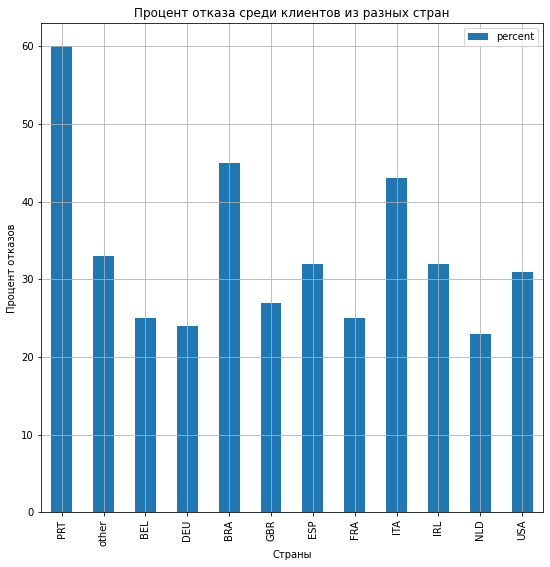

In [408]:
# Проверим зависимость вероятности отказа от страны клиента 
test['country'] = test['country'].apply(replacer)
test.query('is_canceled == 1').groupby('country')['id'].count()
countries = test['country'].unique()
country_cancel_shares = []

for country in countries:
    country_count = int(test.query('country == @country')['id'].count())
    country_cancel_count = int(test.query('country == @country & is_canceled == 1')['id'].count())
    country_cancel_share = round(country_cancel_count / country_count * 100)
    country_cancel_shares.append([country, country_cancel_share])
    
print(country_cancel_shares)
    
country_cancel_shares = pd.DataFrame(country_cancel_shares, columns=['country', 'percent'])

ax = country_cancel_shares.plot(kind='bar', x='country', figsize=(9, 9), grid=True)
ax.set_title('Процент отказа среди клиентов из разных стран')
ax.set_xlabel('Страны')
ax.set_ylabel('Процент отказов')

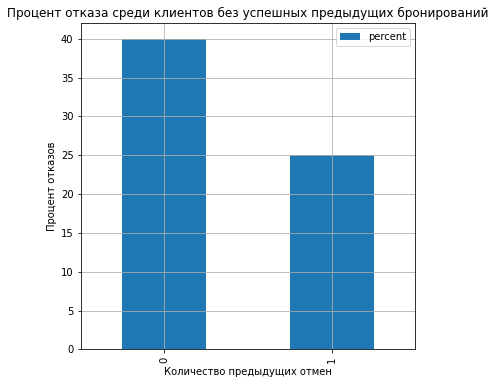

In [409]:
new_clients_cancel_percent = []
previous_cancellations = test['previous_cancellations'].unique()
for number in previous_cancellations:
    clients_count = int(test.query(
        'previous_cancellations == @number & previous_bookings_not_canceled == 0')['id'].count())
    clients_cancel_count = int(test.query(
        'previous_cancellations == @number & is_canceled == 1 & previous_bookings_not_canceled == 0')['id'].count())
    if clients_count != 0:
        clients_cancel_percent = round(clients_cancel_count / clients_count * 100)
        new_clients_cancel_percent.append([number, clients_cancel_percent, clients_count])

new_clients_cancel_percent = pd.DataFrame(
    new_clients_cancel_percent, columns=['previous_cancellations', 'percent', 'clients_count'])
display(new_clients_cancel_percent)

ax = new_clients_cancel_percent.plot(
    kind='bar', x='previous_cancellations', y='percent', figsize=(6, 6), grid=True)
ax.set_title('Процент отказа среди клиентов без успешных предыдущих бронирований')
ax.set_xlabel('Количество предыдущих отмен')
ax.set_ylabel('Процент отказов')

cancel_share_for_all_new_clients = round((
    test.query('previous_bookings_not_canceled == 0 & is_canceled == 1')['id'].count() / 
    test.query('previous_bookings_not_canceled == 0')['id'].count() * 100), 2)

print('Общая доля отказов по всем клиентам, ранее не пользовавшихся услугами отеля', 
      cancel_share_for_all_new_clients, '%.')

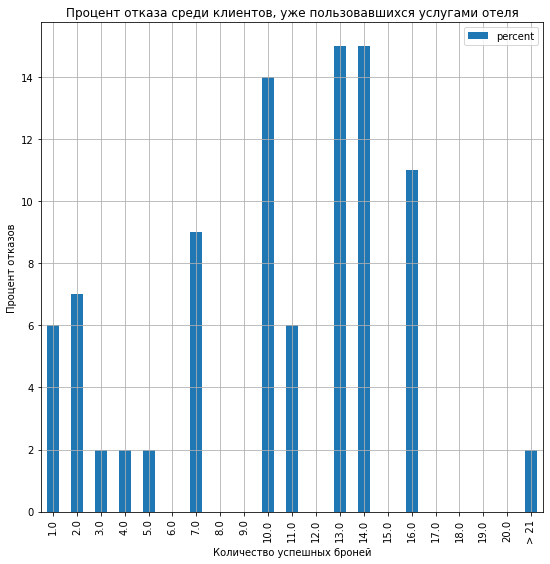

In [410]:
# Проверим процент отказов среди клиентов, ранее пользовавшихся услугами отеля

test.loc[test['previous_bookings_not_canceled'] > 20, 'successful_bookings'] = 21
test['successful_bookings'] = test['successful_bookings'].fillna(test['previous_bookings_not_canceled'])

repeated_clients_cancel_percent = []

successful_bookings = sorted(test.query(
    'previous_bookings_not_canceled > 0')['successful_bookings'].unique())

for value in successful_bookings:
    clients_count = int(test.query(
        'successful_bookings == @value')['id'].count())
    clients_cancel_count = int(test.query(
        'is_canceled == 1 & successful_bookings == @value')['id'].count())
    if clients_count != 0:
        clients_cancel_percent = round(clients_cancel_count / clients_count * 100)
        repeated_clients_cancel_percent.append([value, clients_cancel_percent, clients_count])

repeated_clients_cancel_percent = pd.DataFrame(
    repeated_clients_cancel_percent, columns=['successful_bookings', 'percent', 'clients_count'])
repeated_clients_cancel_percent.loc[
    repeated_clients_cancel_percent['successful_bookings'] == 21, 'successful_bookings'] = '> 21'

# display(repeated_clients_cancel_percent)

ax = repeated_clients_cancel_percent.plot(
    kind='bar', x='successful_bookings', y='percent', figsize=(9, 9), grid=True)
ax.set_title('Процент отказа среди клиентов, уже пользовавшихся услугами отеля')
ax.set_xlabel('Количество успешных броней')
ax.set_ylabel('Процент отказов')

cancel_share_for_all_repeated_clients = round((
    test.query('previous_bookings_not_canceled > 0 & is_canceled == 1')['id'].count() / 
    test.query('previous_bookings_not_canceled > 0')['id'].count() * 100), 2)

print('Общая доля отказов по всем клиентам, ранее пользовавшихся услугами отеля', cancel_share_for_all_repeated_clients, '%.')

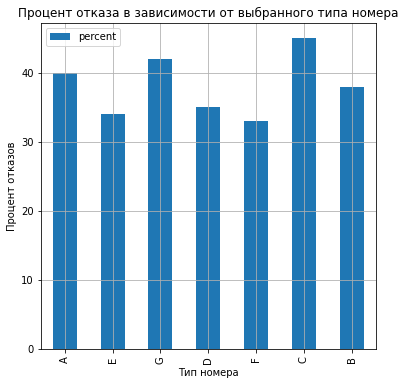

In [411]:
room_type_cancel_percent = []
room_types = test['reserved_room_type'].unique()
for value in room_types:
    clients_count = int(test.query('reserved_room_type == @value')['id'].count())
    clients_cancel_count = int(test.query(
        'reserved_room_type == @value & is_canceled == 1')['id'].count())
    if clients_count != 0:
        clients_cancel_percent = round(clients_cancel_count / clients_count * 100)
        room_type_cancel_percent.append([value, clients_cancel_percent, clients_count])

room_type_cancel_percent = pd.DataFrame(
    room_type_cancel_percent, columns=['room_type', 'percent', 'clients_count'])
display(room_type_cancel_percent)

ax = room_type_cancel_percent.plot(
    kind='bar', x='room_type', y='percent', figsize=(6, 6), grid=True)
ax.set_title('Процент отказа в зависимости от выбранного типа номера')
ax.set_xlabel('Тип номера')
ax.set_ylabel('Процент отказов')

In [412]:
cancel_share_for_clients_with_children_or_babies = round((
    test.query('(children > 0 | babies > 0) & is_canceled == 1')['id'].count() / 
    test.query('children > 0 | babies > 0')['id'].count() * 100), 2)

cancel_share_for_clients_with_both_children_or_babies = round((
    test.query('(children > 0 & babies > 0) & is_canceled == 1')['id'].count() / 
    test.query('children > 0 & babies > 0')['id'].count() * 100), 2)

cancel_share_for_clients_with_children_no_babies = round((
    test.query('children > 0 & babies == 0 & is_canceled == 1')['id'].count() / 
    test.query('children > 0 & babies == 0')['id'].count() * 100), 2)

cancel_share_for_clients_with_babies_no_children = round((
    test.query('children == 0 & babies > 0 & is_canceled == 1')['id'].count() / 
    test.query('children == 0 & babies > 0')['id'].count() * 100), 2)

cancel_share_for_clients_without_children_and_babies = round((
    test.query('children == 0 & babies == 0 & is_canceled == 1')['id'].count() / 
    test.query('children == 0 & babies == 0')['id'].count() * 100), 2)

cancel_share_for_clients_with_babies = round((
    test.query('babies > 0 & is_canceled == 1')['id'].count() / 
    test.query('babies > 0')['id'].count() * 100), 2)


print('Общая доля отказов по всем клиентам c детьми или младенцами', 
      cancel_share_for_clients_with_children_or_babies, '%.')
print('Общая доля отказов по всем клиентам c детьми и младенцами одновременно', 
      cancel_share_for_clients_with_both_children_or_babies, '%.')
print('Общая доля отказов по всем клиентам c детьми, но без младенцев', 
      cancel_share_for_clients_with_children_no_babies, '%.')
print('Общая доля отказов по всем клиентам c младенцами, но без детей старше трех лет', 
      cancel_share_for_clients_with_babies_no_children, '%.')
print('Общая доля отказов по всем клиентам с младенцами (неважно, есть ли еще дети)', 
      cancel_share_for_clients_with_babies, '%.')
print('Общая доля отказов по всем клиентам без любых детей и младенцев', 
      cancel_share_for_clients_without_children_and_babies, '%.')



## Вывод

### Подготовка данных
В ходе решения задачи построения модели, предсказывающей отказ клиента от брони отеля, были импортированы датасеты, данные проверены и очищены от выбросов и ошибок. На основании очищенных данных были сформированы обучающий и проверочный датасеты: категориальные признаки были кодированы, численные масштабированы, произведена проверка баланса классов. 

Размер обучающего датасета 64907 строки, 40 колонок. Размер проверочного датасета 32255 строк, 40 колонок.

### Признаки "ненадежного" клиента
На основании исследовательского анализа данных тестового датасета был составлен портрет клиента, склонного к отказу от брони. 

Общая доля отказов от брони среди клиентов отеля 38.94 %.

К отказу от брони наиболее склонны клиенты из Португалии (60 % отказов), Бразилии (45 % отказов) и Италии (43 % отказов). Процент отказа по остальным странам существенно ниже и составляет 23 - 33 %.

Из новых клиентов от брони отказываются 40 %. Процент отказов среди клиентов, ранее пользовавшихся услугами отеля, значительно ниже и составляет менее 5 %.

Наличие детей не влияет на надежность клиента: клиенты с детьми и без детей склонны к отказу от брони примерно одинаково. Зато наличие младенца понижает риск отказа: доля отказов по всем клиентам с младенцами (неважно, есть ли еще дети) 13.29 %. 

Процент отказов мало зависит от типа забронированного номера, но по номерам категории D, E, F процент отказов несколько ниже, чем средний, и составляет 33 - 35 %, в то время как самый высокий процент отказа в категории C - 45 % броней отменяются.

### Обучение и выбор моделей
На основании сформированных датасетов были обучены три вида моделей: решающее дерево, логистическая регрессия и случайный лес. На валидационной выборке, выделенной из обучающего датасета подобраны гиперпараметры. Модели были оценены кросс-валидацией, лучшей по метрике F1-score признана модель логистической регрессии:
> LogisticRegression(random_state=12345, solver='liblinear', tol=1e-04)

Метрики этой модели: 

In [413]:
best_regression_f1_score_valid
regression_mean_f1_score
regression_f1_score_test

regression_scores = [['на валидационной выборке', best_regression_f1_score_valid],
                      ['на кросс-валидации', regression_mean_f1_score],
                      ['на тестовой выборке', regression_f1_score_test]]
output = pd.DataFrame(regression_scores, columns=['выборка', 'f1_score'])
output

Модель была проверена на тестовом датасете и показала метрику `f1-score = 0.6268`.

### Расчет окупаемости внедрения модели
Прибыль от внедрения модели была оценена в 11_112_732 рублей. При бюджете на разработку модели 400_000 рублей, внедрение модели окупится в течение года. 

Доля ложно-положительных предсказаний модели 12% - в этих ситуациях есть риск отказа клиента от услуг отеля из-за предложения внести депозит. Этот риск выглядит приемлемым.

Модель рекомендована к дообучению и внедрению.